In [49]:
# To force use of shapely
import os
os.environ['USE_PYGEOS'] = '0'

import geopandas as gpd
from affine import Affine
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [72]:
(upper_left_y - upper_left_x)/20.

900000.0

In [73]:
# Define grid parameters

easegrid2_epsg = 6932

nrow = 20  #2880
ncol = 20  #2880
upper_left_x = -9000000.0
upper_left_y = 9000000.0
width = 900000.0  #100000.0
height = -900000.0  #-100000.0

# nrow = 151
# ncol = 147
# width = 10000.0
# height = -10000.0
# upper_left_x = -1040000.0
# upper_left_y = -560000.0

map_extent = [upper_left_x, (upper_left_x + (ncol*width)), (upper_left_y + (nrow*height)), upper_left_y]

In [16]:
# Read ross_sea.json file

gdf = gpd.read_file('ross_sea.json')
gdf

,geometry
0,"POLYGON ((-191.09609 -73.84648, -196.32896 -76..."


In [103]:
def get_grid_index(xy):
    geotransform = (upper_left_x, width, 0., upper_left_y, 0., height)
    fwd = Affine.from_gdal(*geotransform)
    col, row = ~fwd * xy
    return (np.floor(row) * ncol) + np.floor(col)

In [104]:
# Get some points from the polygon
coordinates = []
for geometry in gdf.to_crs(easegrid2_epsg).geometry:
    coordinates.append(geometry.exterior.coords.xy)
    
grid_index = [get_grid_index((x, y)) for x, y in zip(*coordinates[0])]
#x, y = coordinates[0][0], coordinates[0][1]
grid_points = pd.Series(1, index=grid_index)
grid_points

230.0    1
230.0    1
230.0    1
210.0    1
210.0    1
209.0    1
209.0    1
209.0    1
209.0    1
209.0    1
228.0    1
228.0    1
249.0    1
249.0    1
250.0    1
230.0    1
dtype: int64

In [105]:
def series_to_grid(series, nrow, ncol):
    """Converts a geopandas.Series to a grid using the index"""
    these_points = series.index < (nrow*ncol - 1)
    
    array_index = series[these_points].index.values.astype(int)  # the array index must be an integer
    
    vector = np.full(nrow*ncol, np.nan)
    vector[array_index] = series[these_points]
    return vector.reshape(nrow, ncol)

In [106]:
grid = series_to_grid(grid_points, nrow, ncol)

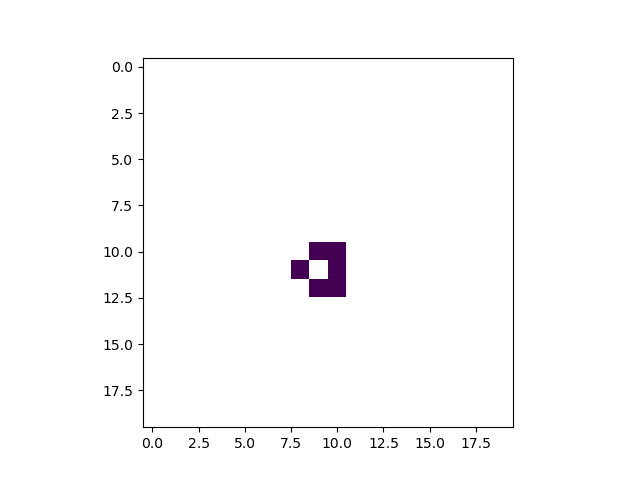

In [107]:
%matplotlib widget
plt.imshow(grid, interpolation='None')

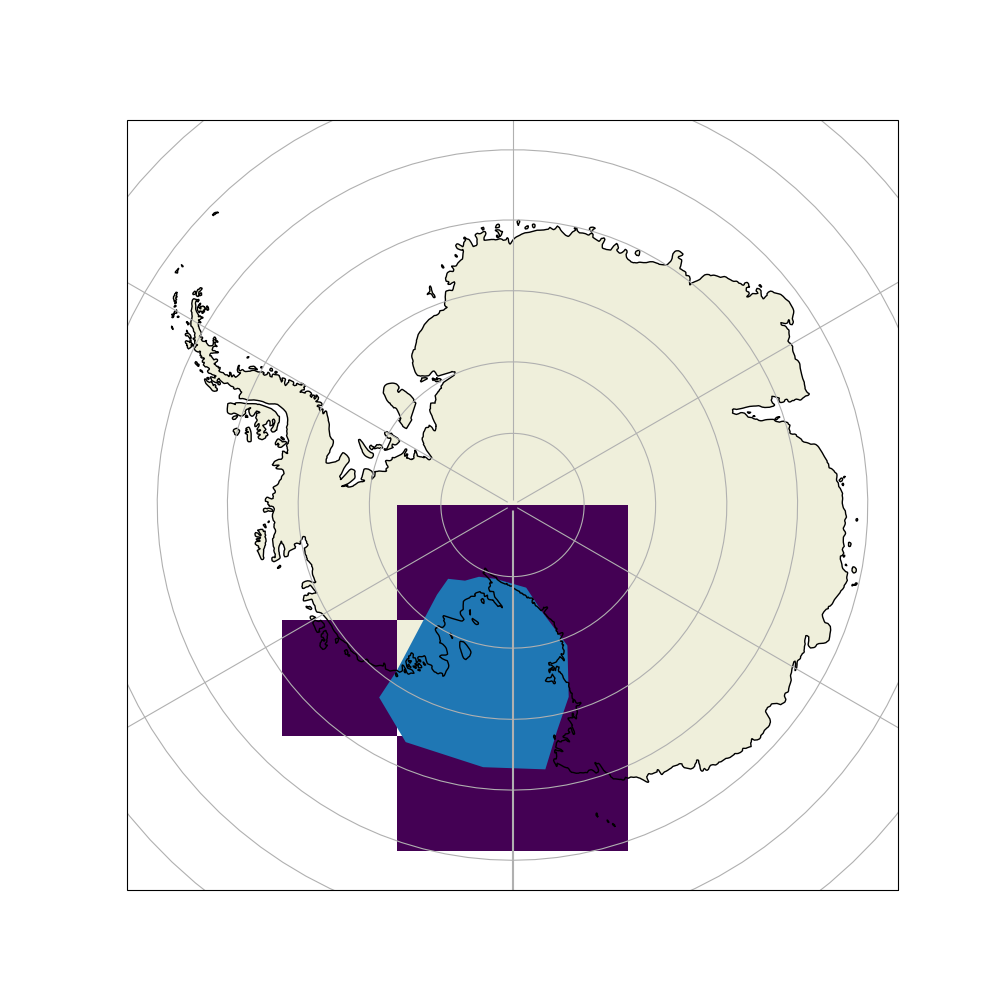

In [108]:
#proj = EASEGrid2South()
plt.close("all")
proj = ccrs.LambertAzimuthalEqualArea(central_latitude=-90)

antarctic_extent = [-3000000.0, 3000000.0, -3000000.0, 3000000.0]
#np.array(map_extent)+np.array([-1e6,-1e6,1e6,1e6])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=proj)
ax.set_extent(antarctic_extent, proj)
ax.add_feature(cfeature.LAND)
ax.gridlines()
ax.coastlines()

gdf.to_crs(easegrid2_epsg).plot(ax=ax)
ax.imshow(grid, interpolation='None', extent=map_extent)
#ax.scatter(x, y, c='r', transform=proj)
#plt.imshow(grids['count_segments'], interpolation='none', extent=map_extent)


In [109]:
geotransform = (upper_left_x, width, 0., upper_left_y, 0., height)
fwd = Affine.from_gdal(*geotransform)

fwd

Affine(900000.0, 0.0, -9000000.0,
       0.0, -900000.0, 9000000.0)

In [110]:
x, y = list(zip(*[fwd * (c+0.5, r+0.5) for r, c in zip(*np.where(np.isfinite(grid)))]))

In [111]:
x, y

((-450000.0, 450000.0, -1350000.0, 450000.0, -450000.0, 450000.0),
 (-450000.0, -450000.0, -1350000.0, -1350000.0, -2250000.0, -2250000.0))

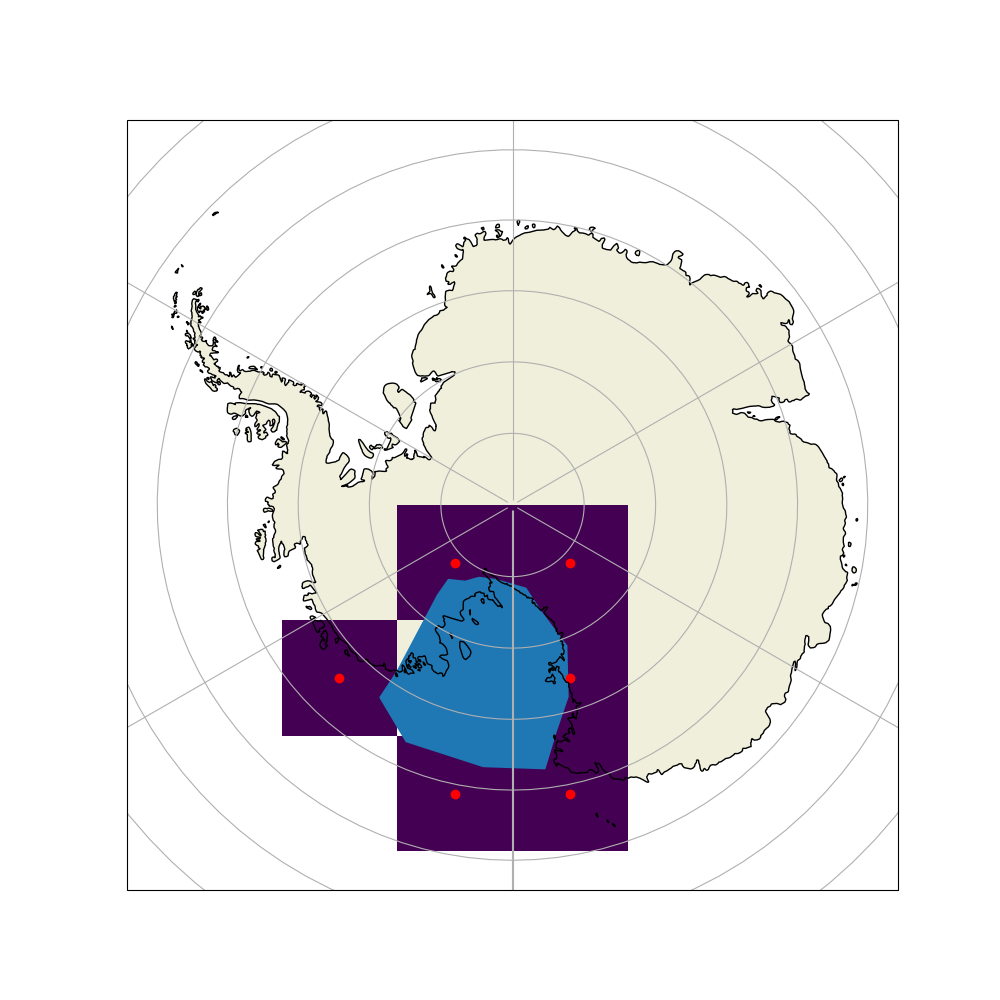

In [112]:
#proj = EASEGrid2South()
plt.close("all")
proj = ccrs.LambertAzimuthalEqualArea(central_latitude=-90)

antarctic_extent = [-3000000.0, 3000000.0, -3000000.0, 3000000.0]
#np.array(map_extent)+np.array([-1e6,-1e6,1e6,1e6])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=proj)
ax.set_extent(antarctic_extent, proj)
ax.add_feature(cfeature.LAND)
ax.gridlines()
ax.coastlines()

gdf.to_crs(easegrid2_epsg).plot(ax=ax)
ax.imshow(grid, interpolation='None', extent=map_extent)
ax.scatter(x, y, c='r', transform=proj)


## Testing with random points

In [126]:
gdf.geometry.bounds

,minx,miny,maxx,maxy
0,-201.333348,-84.712225,-138.890313,-71.325768


In [113]:
import numpy as np
from shapely.geometry import Point, Polygon

def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

In [114]:
polygon = Polygon([[0,0],[0,2],[1.5,1],[0.5,-0.5],[0,0]])
gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[polygon])

In [125]:
x,y = Random_Points_in_Bounds(gdf.geometry, 1000)
df = pd.DataFrame()
df['points'] = list(zip(x,y))
df['points'] = df['points'].apply(Point)
gdf_points = gpd.GeoDataFrame(df, geometry='points')

ValueError: could not convert string to float: 'minx'

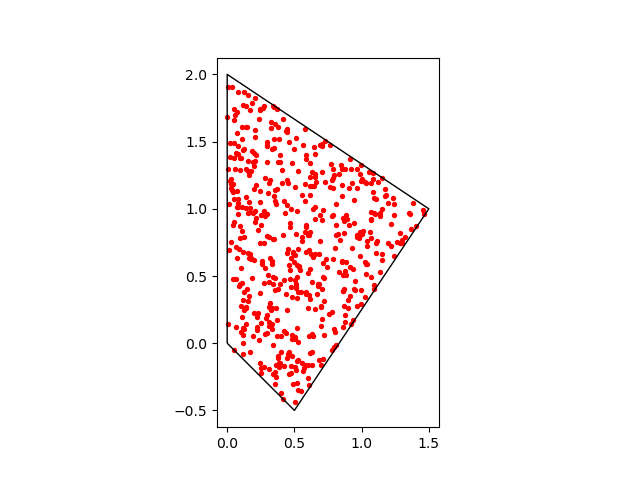

In [120]:
Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

# Keep points in "myPoly"
pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']

# Plot result
import matplotlib.pyplot as plt
base = gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
pnts_in_poly.plot(ax=base, linewidth=1, color="red", markersize=8)
plt.show()